In [325]:
# IMPORTS
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math

In [326]:
# UTILITIES
def deriv2(f, dx):
    fprimeprime = (f[2:] - 2*f[1:-1] + f[0:-2])/dx**2
    return fprimeprime
def deriv1(f, dx):
    fprime = (f[2:] - f[0:-2])/(2*dx)
    return fprime
def deriv1_old(f, dx):
    fprime = (f[2:] - f[1:-1])/dx
    return fprime

In [327]:
# SOL & INITIAL DATA
def solution(t,x):
    f = np.exp(-(t-x)**2)
    return f

def initial_data(x):
    f = np.exp(-x**2) 
    fprime = 2.*x*np.exp(-x**2) 
    #time derivative of f = 2x*-x^2
    return np.array([f,fprime]) 

def uv(x):
    u = np.exp(-x**2)
    v = -1 * np.exp(-x**2)
    return np.array([u,v])

In [328]:
# CHANGE CONSTANTS
def rhs(t, f, a, b, mode):
    dt_u = np.zeros_like(f[0])  
    # CONSTANTS - 1
    if mode == 1:
        sigmax = 0
        dt_u[1:-1] = b * deriv1_old(f[1], dx) - (sigmax * f[0][1:-1])
        dt_v = np.zeros_like(f[1]) 
        dt_v[1:-1] = a * deriv1(f[0], dx) - (sigmax * f[1][1:-1])

        # edited: 
        # not naming issues
        # not sigmax
        # fine if just b or a, fine with dt_v
        # something wrong with deriv1(f[1],dx)
        # deriv1_old seems to be fine?
        return np.array([dt_u, dt_v])
    

    # BUMP FUNCTION - 2
    elif mode == 2: 
        aa = 3
        x0 = 5
        c = 3
        oneg = (-1 * c) + x0
        opos = (1 * c) + x0
        outside = np.logical_or(x<= oneg, x>=opos)
        sigmax = np.piecewise(x, [outside, np.logical_not(outside)], [0, lambda x: np.exp(aa * -1 * (1/((1-((x-x0)**2)/(c**2)))))]) * math.e
        dt_u[1:-1] = b * deriv1(f[1], dx)# - (sigmax[1:-1] * f[0][1:-1])
        dt_v = np.zeros_like(f[1]) 
        dt_v[1:-1] = a * deriv1(f[0], dx)# - (sigmax[1:-1] * f[1][1:-1])

        #deriv1_old fix does not work here, seems to be mostly with dt_u? not as unstable but maybe still off?
        return np.array([dt_u, dt_v]), sigmax
    #GAUSSIAN FUNCTION - 3
    elif mode == 3:
        aa = 0
        x0 = 0
        c = 1
        sigmax = aa * np.exp(-1*((x-x0)**2) / (2*(c)**2)) 
        dt_u[1:-1] = b * deriv1(f[1], dx) - (sigmax[1:-1] * f[0][1:-1])
        dt_v = np.zeros_like(f[1]) 
        dt_v[1:-1] = a * deriv1(f[0], dx) - (sigmax[1:-1] * f[1][1:-1])
        return np.array([dt_u, dt_v]), "temp"
    else:
        dt_phi = np.zeros_like(f[0])
        dt_phi[1:-1] = f[1][1:-1]
        dt_psi = np.zeros_like(f[1])
        dt_psi[1:-1] = deriv2(f[0], dx)
        sigmax = 0
        return np.array([dt_phi, dt_psi]), sigmax
    

In [329]:
# BOUNDARY & RK
def dirichlet_boundary_condition(f):
    fout = f.copy()
    fout[0][0] = 0.
    fout[0][-1] = 0.
    fout[1][0] = 0.
    fout[1][-1] = 0.
    return fout

#periodic will just loop back around
def periodic_boundary_condition(f):
    fout = f.copy()
    fout[0][0] = f[0][-2]
    fout[0][-1] = f[0][1]
    fout[1][0] = f[1][-2]
    fout[1][-1] = f[1][1]
    return fout
    
def rk2step(f, rhs, t, dt, mode_option):
    #rhs(t, f, a, b, mode)
    k1, temp = rhs(t, f, 1, 1, mode_option)
    f1 = f + 1./2.*dt*k1
    f1 = boundary_condition(f1)

    k2, temp = rhs(t + 1./2.*dt, f1, 1, 1, mode_option)
    f2 = f + dt * k2
    f2 = boundary_condition(f2)

    return f2, temp

def rk4step(f, rhs, t, dt, mode_option):
    k1, sigmao = rhs(t, f, 1, 1, mode_option)
    f2 = f + (dt*1/2*k1)
    f2 = boundary_condition(f2)
    k2, sigmao = rhs(t + 1./2.*dt, f2, 1, 1, mode_option)

    f3 = f + (dt*1/2*k2)
    f3 = boundary_condition(f3)
    k3, sigmao = rhs(t + 1./2.*dt, f3, 1, 1, mode_option)

    f4 = f + (dt*k3)
    f4 = boundary_condition(f4)
    k4, sigmao = rhs(t + dt, f4, 1, 1, mode_option)

    final = f + 1/6*(k1 + 2*k2 + 2*k3 + k4)*dt
    final = boundary_condition(final)
    return final, sigmao

NOTES for 10/21
- added mode_option to update for real, everything's fine except constant
- use mode_option 2 with constant c = 0 for nothing?
- rk2step and 2k4 step makes no difference

0.029999999999999805


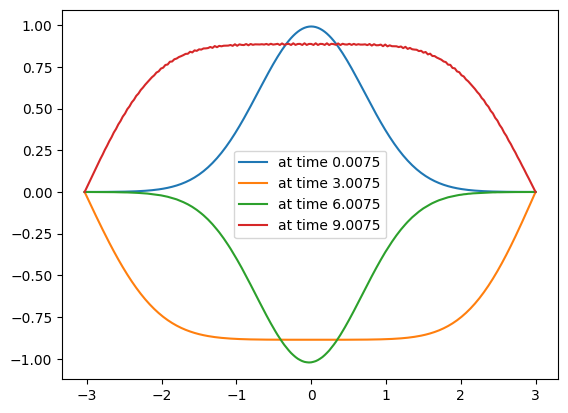

In [330]:
#MAIN
# 1 = constant, 2 = bump, 3 = gaussian
# can use mode 2 with c = 0 to do nothing?
mode_option = 4
boundary_condition = dirichlet_boundary_condition

# start and end time
t0 = 0.
t1 = 10

# grid
xmin = -3
xmax = 3
ncells = 200
dx = (xmax - xmin) / ncells
nhalo = 1 

x = np.linspace(xmin - nhalo * dx, xmax, ncells + 2*nhalo)

# grid spacing
dx = x[1] - x[0]
print(dx)
# time step
dt = dx/4. 

t = t0
f = uv(x)
it = 0
while (t < t1):
    fnext, sigmax = rk2step(f, rhs, t, dt, mode_option) 

    t += dt
    f = fnext

    if(it % 400 == 0):
        plt.plot(x, f[0], label="at time %g" % t)
    it += 1

#plt.plot(x, sigmao, label = "sigmax")
plt.legend(loc='best');

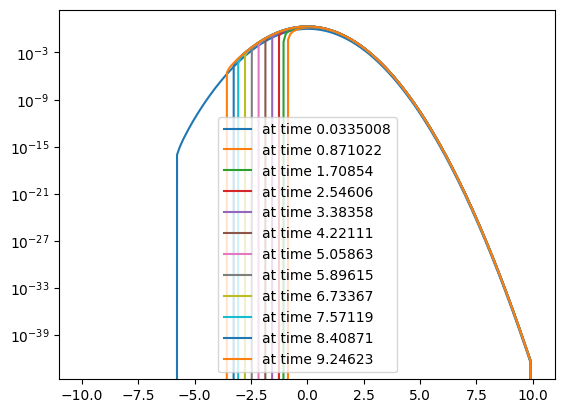

In [331]:
# start and end time
t0 = 0.
t1 = 10

#mode_option_diff = 2
boundary_condition = dirichlet_boundary_condition
# grid
x = np.linspace(-10., 10., 200)


# grid spacing
dx = x[1] - x[0]

# time step
dt = dx/3. # this must be "small enough"

t = t0
f = uv(x)
it = 0
while (t < t1):
    fnext, temp = rk2step (f, rhs, t, dt, 1)

    t += dt
    f = fnext
    
    if(it % 25 == 0):
        plt.semilogy(x, f[0], label="at time %g" % t)
    it += 1
plt.legend(loc='best');
#plt.plot(x, temp, label = "sigmax")